# Analyse Photométrique et Caractérisation d'Amas Stellaire (Calibration Référence g)

## Résumé
Ce notebook présente un pipeline complet de réduction et d'analyse de données photométriques multi-bandes ($g, r, i$). L'objectif est de construire un Diagramme Couleur-Magnitude (CMD) et de déterminer les paramètres physiques fondamentaux de l'amas.

## Méthodologie
Le traitement des données suit les étapes suivantes :
1.  **Résolution Astrométrique :** Identification du champ et calcul de la solution WCS via *Astrometry.net*.
2.  **Photométrie d'Ouverture :** Détection de sources et mesure de flux indépendante sur chaque bande passante.
3.  **Calibration Photométrique (Référence $g$) :** Détermination du Point Zéro ($ZP$) en utilisant uniquement la bande $g$ par rapport au catalogue Pan-STARRS. Ce $ZP$ est ensuite appliqué uniformément aux autres bandes.
4.  **Construction du CMD :** Synthèse des données calibrées en magnitudes apparentes.
5.  **Ajustement d'Isochrones :** Comparaison des données observationnelles avec les modèles d'évolution stellaire (PARSEC) pour estimer le module de distance $\mu$ et l'excès de couleur $E(B-V)$.

In [394]:
import os
import subprocess
import warnings

# Calcul scientifique et traitement de donnees
import numpy as np
from scipy.stats import linregress
from astropy.table import Table

# Gestion des images FITS et WCS
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

# Photometrie et statistiques d'images
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

# Acces aux catalogues en ligne
from astroquery.vizier import Vizier

# Visualisation
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## 1. Configuration et Paramètres de Réduction

Définition des chemins d'accès aux images empilées (stacks) et des paramètres de la PSF (Point Spread Function) pour l'extraction de sources.

In [395]:
# Chemins des fichiers FITS d'entree
stack_g_path = 'stacks/stack_g.fits'
stack_r_path = 'stacks/stack_r.fits'
stack_i_path = 'stacks/stack_i.fits'

# Parametres de detection et de photometrie
fwhm = 5.0                # Largeur a mi-hauteur estimee (pixels)
aperture_radius = 2 * fwhm / 2.355  # Rayon d'ouverture (~2 sigma de la gaussienne)
sigma_thresh = 5.0        # Seuil de detection (n-sigma au-dessus du fond)

# Parametres de calibration et catalogue
match_radius_arcsec = 5   # Rayon de tolérance pour l'appariement croise
use_panstarrs = True      # True: Pan-STARRS (recommande), False: Gaia
field_radius_deg = 0.4    # Rayon du cone search pour le catalogue

# Parametres d'ajustement d'isochrone (Conditions initiales)
DISTANCE_MODULUS = 11.3   # Module de distance (m - M)
E_BV = 0.83               # Rougissement interstellaire E(B-V)

# Configuration du Diagramme HR final
PLOT_COLOR_1 = 'g'
PLOT_COLOR_2 = 'r'
PLOT_MAG = 'g'

## 2. Résolution Astrométrique

Utilisation du moteur `solve-field` (Astrometry.net) pour générer une solution WCS. Cette étape est critique pour convertir les coordonnées pixels $(x, y)$ en coordonnées équatoriales $(\alpha, \delta)$ nécessaires à l'interrogation des catalogues.

In [396]:
def solve_astrometry(input_fits):
    """
    Execute astrometry.net sur une image FITS pour generer une solution WCS.
    Genere un nouveau fichier '_wcs.fits' contenant l'en-tete mis a jour.
    """
    output_fits = input_fits.replace('.fits', '_wcs.fits')
    if not os.path.exists(output_fits):
        print(f'Resolution astrometrique en cours pour : {input_fits}...')
        # Commande shell pour solve-field (flag --no-plots pour accelerer)
        cmd = [
            'solve-field', input_fits,
            '--overwrite', '--no-plots', 
            '--new-fits', output_fits
        ]
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    if not os.path.exists(output_fits):
        raise RuntimeError(f'Echec de la resolution astrometrique pour {input_fits}')
    
    print(f'Astrometrie resolue : {output_fits}')
    return output_fits

# Application sur les trois bandes
stack_g_wcs = solve_astrometry(stack_g_path)
stack_r_wcs = solve_astrometry(stack_r_path)
stack_i_wcs = solve_astrometry(stack_i_path)

Astrometrie resolue : stacks/stack_g_wcs.fits
Astrometrie resolue : stacks/stack_r_wcs.fits
Astrometrie resolue : stacks/stack_i_wcs.fits


## 3. Prétraitement des Images

Chargement des données et estimation du fond de ciel. Une soustraction du fond est effectuée en utilisant une statistique *sigma-clipped* (médiane) pour isoler le signal stellaire du bruit de fond.

In [397]:
g_hdul = fits.open(stack_g_wcs)
r_hdul = fits.open(stack_r_wcs)
i_hdul = fits.open(stack_i_wcs)

g_data = g_hdul[0].data.astype(float)
r_data = r_hdul[0].data.astype(float)
i_data = i_hdul[0].data.astype(float)

# Estimation et soustraction du fond de ciel (Background)
mean_g, median_g, std_g = sigma_clipped_stats(g_data, sigma=3.0)
mean_r, median_r, std_r = sigma_clipped_stats(r_data, sigma=3.0)
mean_i, median_i, std_i = sigma_clipped_stats(i_data, sigma=3.0)

g_data -= median_g
r_data -= median_r
i_data -= median_i

# Initialisation du WCS de reference (basé sur la bande g)
wcs = WCS(g_hdul[0].header)
print('Donnees chargees et fond de ciel soustrait.')

Donnees chargees et fond de ciel soustrait.


## 4. Extraction de Sources et Photométrie Instrumentale

Nous utilisons l'algorithme `DAOStarFinder` pour la détection de sources ponctuelles. La photométrie est ensuite réalisée par ouverture circulaire. 

La magnitude instrumentale est calculée selon la relation :
$$ m_{inst} = -2.5 \log_{10}(\text{Flux}) $$

Sources detectees : g=1549, r=2403, i=1859


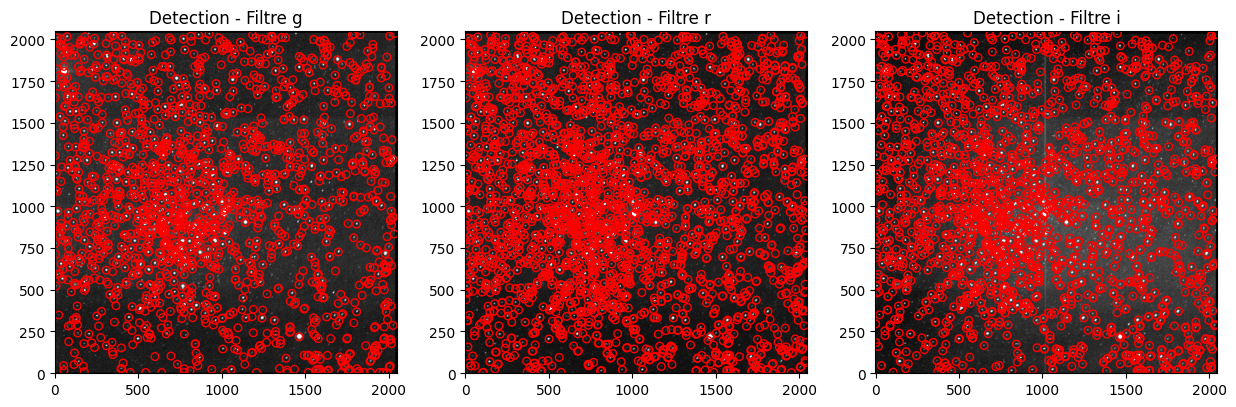

In [398]:
def detect_sources(data, fwhm, sigma):
    """Detection de sources ponctuelles via DAOStarFinder."""
    mean, median, std = sigma_clipped_stats(data, sigma=2.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma * std)
    return daofind(data - median)

# Detection independante sur chaque filtre
sources_g = detect_sources(g_data, fwhm, sigma_thresh)
sources_r = detect_sources(r_data, fwhm, sigma_thresh)
sources_i = detect_sources(i_data, fwhm, sigma_thresh)

print(f"Sources detectees : g={len(sources_g)}, r={len(sources_r)}, i={len(sources_i)}")

# Visualisation des detections
plt.figure(figsize=(15, 5))
titles = ['Filtre g', 'Filtre r', 'Filtre i']
datasets = [g_data, r_data, i_data]
sources_list = [sources_g, sources_r, sources_i]

for idx, (data, sources, title) in enumerate(zip(datasets, sources_list, titles)):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(data, cmap='gray', origin='lower', 
               vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
    plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none')
    plt.title(f'Detection - {title}')
plt.show()

In [399]:
# Extraction des positions (centroides)
positions_g = np.transpose((sources_g['xcentroid'], sources_g['ycentroid']))
positions_r = np.transpose((sources_r['xcentroid'], sources_r['ycentroid']))
positions_i = np.transpose((sources_i['xcentroid'], sources_i['ycentroid']))

# Definition des ouvertures
ap_g = CircularAperture(positions_g, r=aperture_radius)
ap_r = CircularAperture(positions_r, r=aperture_radius)
ap_i = CircularAperture(positions_i, r=aperture_radius)

# Mesure du flux
phot_g = aperture_photometry(g_data, ap_g)
phot_r = aperture_photometry(r_data, ap_r)
phot_i = aperture_photometry(i_data, ap_i)

# Conversion en magnitude instrumentale
phot_g['mag_inst'] = -2.5 * np.log10(phot_g['aperture_sum'])
phot_r['mag_inst'] = -2.5 * np.log10(phot_r['aperture_sum'])
phot_i['mag_inst'] = -2.5 * np.log10(phot_i['aperture_sum'])

print('Photometrie d\'ouverture terminee.')

Photometrie d'ouverture terminee.


## 5. Conversion de Coordonnées

Transformation des positions pixels des sources détectées en coordonnées célestes (RA/DEC) en utilisant la solution WCS calculée précédemment.

In [400]:
pix_g = np.transpose((phot_g['xcenter'], phot_g['ycenter']))
pix_r = np.transpose((phot_r['xcenter'], phot_r['ycenter']))
pix_i = np.transpose((phot_i['xcenter'], phot_i['ycenter']))

# Conversion pixels -> monde via le WCS de reference
world_g = wcs.all_pix2world(pix_g, 1)
world_r = wcs.all_pix2world(pix_r, 1)
world_i = wcs.all_pix2world(pix_i, 1)

coords_g = SkyCoord(ra=world_g[:,0]*u.deg, dec=world_g[:,1]*u.deg)
coords_r = SkyCoord(ra=world_r[:,0]*u.deg, dec=world_r[:,1]*u.deg)
coords_i = SkyCoord(ra=world_i[:,0]*u.deg, dec=world_i[:,1]*u.deg)

print('Coordonnees celestes calculees.')

Coordonnees celestes calculees.


## 6. Acquisition du Catalogue de Référence

Téléchargement des données photométriques de référence (Pan-STARRS DR1 ou Gaia DR3) via Vizier pour la région couvrant le champ observé. Ces données serviront d'étalons standards pour la calibration.

In [401]:
Vizier.ROW_LIMIT = 50000
ra_center, dec_center = np.median(world_g[:,0]), np.median(world_g[:,1])
center = SkyCoord(ra_center, dec_center, unit='deg')

if use_panstarrs:
    # Requete Pan-STARRS (filtre sur les magnitudes pour eviter la saturation/bruit)
    filters = {
        "gmag": "<12",
        "rmag": "<12",
        "imag": "<12"
    }
    v = Vizier(columns=['objID','RAJ2000','DEJ2000','gmag','rmag', 'imag'], column_filters=filters)
    res = v.query_region(center, radius=field_radius_deg*u.deg, catalog='II/349/ps1')
    catalog = res[0]
    catalog.rename_columns(['RAJ2000','DEJ2000'], ['ra','dec'])
    print('Catalogue Pan-STARRS telecharge avec succes.')
    
    # Nettoyage des donnees manquantes
    for mag_col in ['gmag','rmag', 'imag']:
        mask_invalid = catalog[mag_col] == ''
        catalog = catalog[~mask_invalid]
        catalog[mag_col] = catalog[mag_col].astype(float)
else:
    # Fallback sur Gaia DR3 (Attention aux bandes passantes differentes)
    v = Vizier(columns=['RA_ICRS','DE_ICRS','Gmag','BPmag','RPmag'])
    res = v.query_region(center, radius=field_radius_deg*u.deg, catalog='I/355/gaiadr3')
    catalog = res[0]
    catalog.rename_columns(['RA_ICRS','DE_ICRS'], ['ra','dec'])
    print('Catalogue Gaia telecharge avec succes.')

print(f'Nombre d\'entrees dans le catalogue : {len(catalog)}')
ref_coords = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')

Catalogue Pan-STARRS telecharge avec succes.
Nombre d'entrees dans le catalogue : 50


## 7. Calibration Photométrique Relative (Référence $g$)

Nous établissons la relation de calibration en utilisant **uniquement** la bande $g$ comme référence. Le Point Zéro ($ZP$) et la Pente ($\alpha$) calculés pour $g$ sont ensuite appliqués aux autres bandes ($r$ et $i$).

Cette approche suppose une homogénéité de la réponse instrumentale (gain, efficacité quantique relative) et des conditions atmosphériques entre les filtres pour cette première analyse.

$$ m_{std, g} = \alpha_g \cdot m_{inst, g} + ZP_g $$

--- Calibration Reference (g) ---
  Sources appariees : 19
  Zero-Point (ZP)   : 21.231
  Pente (Slope)     : 0.828
  Correlation (r)   : 0.942


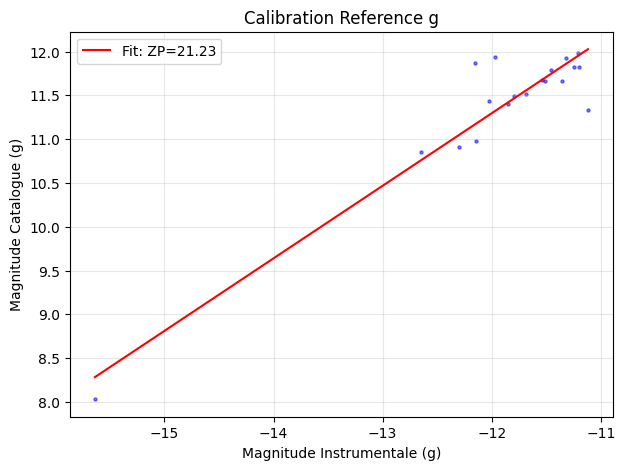

In [402]:
# Calibration basee uniquement sur le filtre 'g'
filt_ref = 'g'
phot_table = phot_g
coords_table = coords_g

# Appariement spatial (Cross-match) pour le filtre de reference
idx, d2d, _ = coords_table.match_to_catalog_sky(ref_coords)
mask = d2d < match_radius_arcsec * u.arcsec
matched_inst = phot_table[mask]
matched_ref = catalog[idx[mask]]

mag_inst = np.array(matched_inst['mag_inst'])
mag_ref = np.array(matched_ref[f'{filt_ref}mag'])

# Filtrage des valeurs aberrantes ou invalides
valid_mask = np.isfinite(mag_inst) & np.isfinite(mag_ref) & (mag_ref < 99)
mag_inst_valid = mag_inst[valid_mask]
mag_ref_valid = mag_ref[valid_mask]

if len(mag_inst_valid) == 0:
    raise RuntimeError("Aucune source appariee pour la calibration. Verifiez l'astrometrie ou les seuils.")

# Regression Lineaire sur g
slope_global, intercept_global, r_val, _, _ = linregress(mag_inst_valid, mag_ref_valid)
ZP_global = intercept_global

print(f"--- Calibration Reference ({filt_ref}) ---")
print(f"  Sources appariees : {len(mag_inst_valid)}")
print(f"  Zero-Point (ZP)   : {ZP_global:.3f}")
print(f"  Pente (Slope)     : {slope_global:.3f}")
print(f"  Correlation (r)   : {r_val:.3f}")

# Graphique de calibration
plt.figure(figsize=(7, 5))
plt.scatter(mag_inst_valid, mag_ref_valid, s=5, alpha=0.5, c='blue')
x_fit = np.array([np.min(mag_inst_valid), np.max(mag_inst_valid)])
y_fit = x_fit * slope_global + ZP_global
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: ZP={ZP_global:.2f}')
plt.title(f"Calibration Reference {filt_ref}")
plt.xlabel('Magnitude Instrumentale (g)')
plt.ylabel('Magnitude Catalogue (g)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Construction du Diagramme Couleur-Magnitude (CMD)

Application de la solution photométrique globale ($ZP_g, \alpha_g$) à l'ensemble des filtres. Nous effectuons ensuite une intersection stricte des catalogues de détection ($g \cap r \cap i$) pour ne conserver que les sources détectées dans les trois bandes, garantissant des couleurs fiables.

--- Filtrage Spatial ---
  Centre estime (RA, Dec) : 351.1694, 61.5674
  Rayon de coupure        : 0.15 deg
  Etoiles totales (3 bandes): 1017
  Membres retenus (Rayon) : 676
351.48030436463114 350.6482573595031


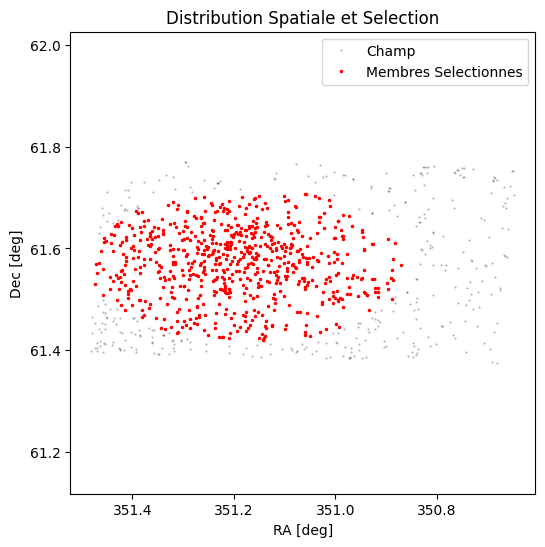

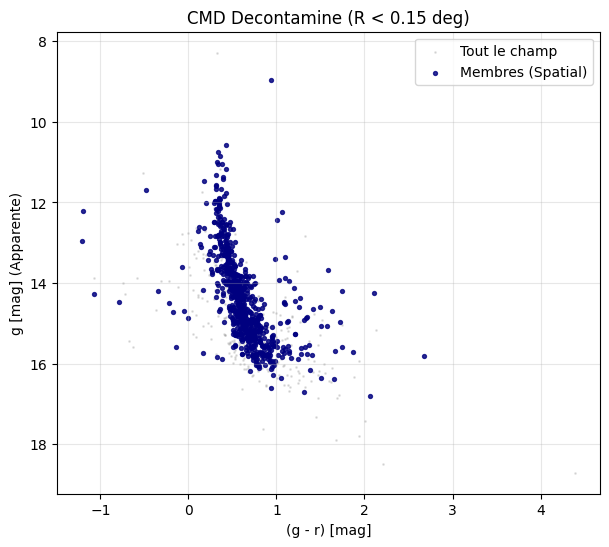

In [ ]:
# --------------------------------------------------------------------------------
# 8. Construction du CMD et Filtrage Spatial des Membres
# --------------------------------------------------------------------------------

# --- 1. Application de la calibration globale ---
phot_g['mag_cal'] = phot_g['mag_inst'] * slope_global + ZP_global
phot_r['mag_cal'] = phot_r['mag_inst'] * slope_global + ZP_global
phot_i['mag_cal'] = phot_i['mag_inst'] * slope_global + ZP_global

# --- 2. Appariement multi-bandes (Intersection g n r n i) ---
# Intersection g-r
idx_gr, d2d_gr, _ = coords_g.match_to_catalog_sky(coords_r)
mask_gr = d2d_gr < match_radius_arcsec*u.arcsec

coords_g_matched_gr = coords_g[mask_gr]
phot_g_matched_gr = phot_g[mask_gr]
phot_r_matched_gr = phot_r[idx_gr[mask_gr]]

# Intersection (g-r)-i
idx_gi, d2d_gi, _ = coords_g_matched_gr.match_to_catalog_sky(coords_i)
mask_gi = d2d_gi < match_radius_arcsec*u.arcsec

# Tables finales (Uniquement les sources detectees dans les 3 filtres)
final_phot_g = phot_g_matched_gr[mask_gi]
final_phot_r = phot_r_matched_gr[mask_gi]
final_phot_i = phot_i[idx_gi[mask_gi]]
final_coords = coords_g_matched_gr[mask_gi] # Coordonnees des sources finales

# --- 3. Filtrage Spatial (Selection des membres probables) ---
# On suppose que l'amas est au centre des coordonnees finales
ra_center = np.median(final_coords.ra.deg)
dec_center = np.median(final_coords.dec.deg)
center_coords = SkyCoord(ra_center, dec_center, unit='deg')

# Calcul de la distance angulaire au centre pour chaque etoile
separations = final_coords.separation(center_coords)

# PARAMETRE : Rayon de coupure (a ajuster visuellement)
# Un rayon plus petit = moins de contamination, mais moins d'etoiles
CLUSTER_RADIUS_DEG = 0.15  # Ex: 0.05 degre (~3 arcmin)

mask_spatial = separations < CLUSTER_RADIUS_DEG * u.deg

print(f"--- Filtrage Spatial ---")
print(f"  Centre estime (RA, Dec) : {ra_center:.4f}, {dec_center:.4f}")
print(f"  Rayon de coupure        : {CLUSTER_RADIUS_DEG} deg")
print(f"  Etoiles totales (3 bandes): {len(final_phot_g)}")
print(f"  Membres retenus (Rayon) : {np.sum(mask_spatial)}")

# Visualisation de la selection spatiale
plt.figure(figsize=(6, 6))
plt.plot(final_coords.ra.deg, final_coords.dec.deg, 'k.', ms=1, alpha=0.3, label='Champ')
plt.plot(final_coords[mask_spatial].ra.deg, final_coords[mask_spatial].dec.deg, 'r.', ms=3, label='Membres Selectionnes')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('Distribution Spatiale et Selection')
plt.xlim(min(final_coords.ra.deg)-0.1, max(final_coords.ra.deg)+0.1)
plt.ylim(min(final_coords.dec.deg)-0.1, max(final_coords.dec.deg)+0.1)
print(max(final_coords.ra.deg), min(final_coords.ra.deg))
plt.legend()
plt.gca().invert_xaxis() # Convention astronomique (Est a gauche)
plt.show()

# --- 4. Preparation des donnees pour le CMD (Uniquement les membres) ---
phot_data_matched = {
    'g': final_phot_g['mag_cal'][mask_spatial],
    'r': final_phot_r['mag_cal'][mask_spatial],
    'i': final_phot_i['mag_cal'][mask_spatial]
}

if PLOT_COLOR_1 not in ['g', 'r', 'i'] or PLOT_COLOR_2 not in ['g', 'r', 'i'] or PLOT_MAG not in ['g', 'r', 'i']:
    raise ValueError("Erreur de configuration des filtres.")

mag1 = phot_data_matched[PLOT_COLOR_1]
mag2 = phot_data_matched[PLOT_COLOR_2]
mag_y = phot_data_matched[PLOT_MAG]

color_x = mag1 - mag2

# Masquage des NaN
valid_plot_mask = np.isfinite(color_x) & np.isfinite(mag_y)
color_x_valid = color_x[valid_plot_mask]
mag_y_valid = mag_y[valid_plot_mask]

# --- 5. Trace du CMD Nettoye ---
xlabel = f'({PLOT_COLOR_1} - {PLOT_COLOR_2}) [mag]'
ylabel = f'{PLOT_MAG} [mag] (Apparente)'

plt.figure(figsize=(7,6))
# On affiche tout le champ en gris tres clair pour voir la difference
all_mag1 = final_phot_g['mag_cal'] if PLOT_COLOR_1=='g' else (final_phot_r['mag_cal'] if PLOT_COLOR_1=='r' else final_phot_i['mag_cal'])
all_mag2 = final_phot_g['mag_cal'] if PLOT_COLOR_2=='g' else (final_phot_r['mag_cal'] if PLOT_COLOR_2=='r' else final_phot_i['mag_cal'])
all_mag_y = final_phot_g['mag_cal'] if PLOT_MAG=='g' else (final_phot_r['mag_cal'] if PLOT_MAG=='r' else final_phot_i['mag_cal'])
plt.scatter(all_mag1-all_mag2, all_mag_y, s=1, c='gray', alpha=0.2, label='Tout le champ')

# On affiche les membres en bleu
plt.scatter(color_x_valid, mag_y_valid, s=8, alpha=0.8, c='navy', label='Membres (Spatial)')

plt.gca().invert_yaxis()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f'CMD Decontamine (R < {CLUSTER_RADIUS_DEG} deg)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Export
header_txt = f'{xlabel}    {ylabel}'
np.savetxt('hr_diagram_data.txt', np.column_stack((color_x_valid, mag_y_valid)), header=header_txt)

## 9. Ajustement d'Isochrones et Paramètres Physiques

Superposition des modèles théoriques (isochrones PARSEC) sur les données observationnelles. L'ajustement permet de déduire :
1.  **L'Âge de l'amas** (sélection du modèle d'isochrone approprié).
2.  **La Distance** via le module de distance $\mu = m - M$.
3.  **L'Extinction Interstellaire** $A_\lambda$ liée à l'excès de couleur $E(B-V)$.

Les isochrones en magnitude absolue ($M$) sont converties en magnitudes apparentes ($m$) selon :
$$ m_\lambda = M_\lambda + \mu + A_\lambda $$
$$ A_\lambda = R_\lambda \cdot E(B-V) $$

--- Parametres d'Ajustement ---
  Module de distance (mu) : 11.30 mag
  Rougissement E(B-V)     : 0.830 mag
  => Decalage Couleur (X) : 0.748 mag
  => Decalage Mag (Y)     : 13.933 mag


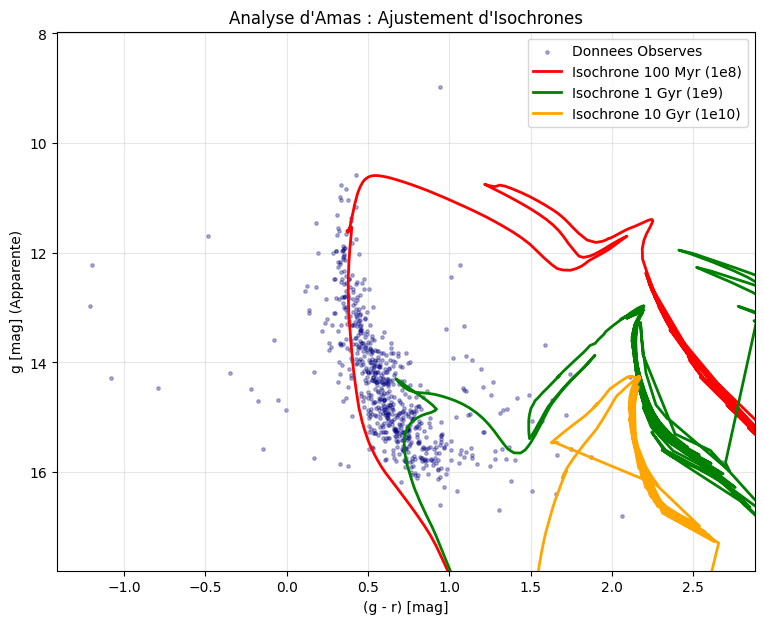

In [404]:
# Coefficients d'extinction (Loi de rougissement standard Schlafly & Finkbeiner 2011)
EXTINCTION_COEFFS = {
    'g': 3.172 * E_BV,
    'r': 2.271 * E_BV,
    'i': 1.682 * E_BV
}

# Mappage des colonnes du fichier d'isochrone (Format PARSEC/CMD)
# Indices negatifs : comptage depuis la fin du fichier pour robustesse
ISO_COL_MAP = {
    'g': -4, # gP1mag
    'r': -3, # rP1mag
    'i': -2  # iP1mag
}

def read_isochrone(file_path, col_map, f1, f2, mag_f):
    """
    Lit un fichier isochrone .dat et extrait les magnitudes absolues M.
    Retourne : couleur (M_f1 - M_f2), magnitude (M_mag_f)
    """
    try:
        f1_idx = col_map[f1]
        f2_idx = col_map[f2]
        mag_idx = col_map[mag_f]
    except KeyError as e:
        print(f"Erreur de mappage : Filtre {e.args[0]} inconnu.")
        return None, None

    try:
        # Chargement du fichier texte, ignore les commentaires '#'
        iso_data = np.loadtxt(file_path, comments='#')
    except Exception as e:
        print(f"Erreur lecture fichier {file_path}: {e}")
        return None, None
    
    # Extraction des colonnes (Magnitudes Absolues)
    try:
        mag1_iso_abs = iso_data[:, f1_idx]
        mag2_iso_abs = iso_data[:, f2_idx]
        mag_iso_abs = iso_data[:, mag_idx]
    except IndexError:
        print("Erreur d'indexation des colonnes dans le fichier isochrone.")
        return None, None

    # Calcul de la couleur theorique
    color_iso_abs = mag1_iso_abs - mag2_iso_abs
    return color_iso_abs, mag_iso_abs

# Dictionnaire des modeles d'isochrones disponibles
iso_files = {
    '100 Myr (1e8)': 'iso_e8.dat',
    '1 Gyr (1e9)': 'iso_e9.dat',
    '10 Gyr (1e10)': 'iso_e10.dat',
    # '20 Myr (2e7)': 'iso_20e6.dat' # Decommenter si necessaire
}

# Chargement des donnees isochrones
iso_data_loaded = {}
for label, path in iso_files.items():
    color, mag = read_isochrone(path, ISO_COL_MAP, PLOT_COLOR_1, PLOT_COLOR_2, PLOT_MAG)
    if color is not None and mag is not None:
        iso_data_loaded[label] = (color, mag)

# Calcul des decalages photometriques
A_mag = EXTINCTION_COEFFS[PLOT_MAG]
A_color1 = EXTINCTION_COEFFS[PLOT_COLOR_1]
A_color2 = EXTINCTION_COEFFS[PLOT_COLOR_2]
E_color = A_color1 - A_color2 # E(couleur) = A_1 - A_2

print("--- Parametres d'Ajustement ---")
print(f"  Module de distance (mu) : {DISTANCE_MODULUS:.2f} mag")
print(f"  Rougissement E(B-V)     : {E_BV:.3f} mag")
print(f"  => Decalage Couleur (X) : {E_color:.3f} mag")
print(f"  => Decalage Mag (Y)     : {(DISTANCE_MODULUS + A_mag):.3f} mag")

# --- Trace Final ---
plt.figure(figsize=(9, 7))

# 1. Donnees observationnelles
plt.scatter(color_x_valid, mag_y_valid, s=6, alpha=0.3, c='navy', label='Donnees Observes')

# 2. Modeles theoriques ajustes
colors = ['red', 'green', 'orange', 'cyan']
for i, (label, (color_iso_abs, mag_iso_abs)) in enumerate(iso_data_loaded.items()):
    # Application du module de distance et de l'extinction
    color_iso_apparent = color_iso_abs + E_color
    mag_iso_apparent = mag_iso_abs + DISTANCE_MODULUS + A_mag
    
    plt.plot(color_iso_apparent, mag_iso_apparent, 
             color=colors[i % len(colors)], lw=2, label=f'Isochrone {label}')

# Mise en forme du graphique
plt.gca().invert_yaxis()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Analyse d\'Amas : Ajustement d\'Isochrones')
plt.grid(True, alpha=0.3)
plt.legend()

# Ajustement automatique des limites d'axes
try:
    lim_x = np.percentile(color_x_valid, [0, 100])
    lim_y = np.percentile(mag_y_valid, [0, 100])
    plt.xlim(lim_x[0] - 0.2, lim_x[1] + 0.2)
    plt.ylim(lim_y[1] + 1, lim_y[0] - 1)
except (IndexError, NameError):
    pass

plt.show()